## TC3007B
### Natural Language Processing

<br>

#### Activity 2: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


# Equipo
---
Gamaliel Marines Olvera
A01708746

Uri Jared Gopar Morales
A01709413

José Antonio Miranda Baños
A01611795

María Fernanda Moreno Gómez
A01708653

Oskar Adolfo Villa López
A01275287

Luis Ángel Cruz García
A01736345


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


#### Install libraries (if needed)

You may need to install the following libraries to ensure version compatibility. After installing them, please Restart the Session (Runtime -> Restart Session)

In [1]:
# !pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchtext==0.15.2

In [2]:
# !pip install scipy==1.9.3
# !pip install scikit-plot
#you may receive a message of restarting session, this is OK

In [3]:
# !pip install portalocker
#please restar session after this intallation. After restarting go straight to importing the libraries

## Import libraries

In [4]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [6]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [7]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [8]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [9]:
#test tokens
tokens = tokeniser('Welcome to TC3007B')
print(tokens, vocab(tokens))

['welcome', 'to', 'tc3007b'] [3314, 4, 0]


In [10]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [11]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [12]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [13]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [14]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [15]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [16]:
EMBEDDING_SIZE = 300
NEURONS = 256
LAYERS = 2
NUM_CLASSES = 4

In [17]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden, 
                            num_layers=layers, batch_first=True)

        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):

        x = self.embedding_layer(x) 

        # Salida del RNN
        rnn_out, _ = self.rnn(x) 

        # Toma el último estado oculto para clasificación
        out = rnn_out[:, -1, :]  

        # Capa completamente conectada para predecir las clases
        out = self.fc(out)
        return out


In [18]:
def accuracy(model, loader):
    correct = 0
    total = 0
    model.eval() 
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)  
            predictions = model(x)  
            _, predicted = torch.max(predictions, dim=1)  
            correct += (predicted == y).sum().item() 
            total += y.size(0)  
    return correct / total  


In [19]:
import matplotlib.pyplot as plt

def train(model, optimiser, train_loader, epochs=10):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    loss_history = []  # Lista para registrar la pérdida
    
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).long()
            optimiser.zero_grad()
            predictions = model(x)
            loss = loss_fn(predictions, y)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        
        average_loss = total_loss / len(train_loader)
        loss_history.append(average_loss)  # Almacena la pérdida promedio de la época
        print(f'Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}')
    
    # Graficar la pérdida después del entrenamiento
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_history, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()


In [20]:
def sample_text(model, vocab, text):
    model.eval()
    with torch.no_grad():
        # Tokeniza el texto y convierte en índices
        tokens = [vocab[token] for token in text.lower().split()]
        tokens_tensor = torch.tensor([tokens]).to(device)
        
        # Predicción
        predictions = model(tokens_tensor)
        _, predicted_label = torch.max(predictions, dim=1)
        return predicted_label.item() 


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            predictions = model(x)
            _, predicted = torch.max(predictions, dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    # Calcula la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


Epoch 1/10, Loss: 0.6351
Epoch 2/10, Loss: 0.2872
Epoch 3/10, Loss: 0.2069
Epoch 4/10, Loss: 0.1476
Epoch 5/10, Loss: 0.1061
Epoch 6/10, Loss: 0.0776
Epoch 7/10, Loss: 0.0539
Epoch 8/10, Loss: 0.0395
Epoch 9/10, Loss: 0.0315
Epoch 10/10, Loss: 0.0249


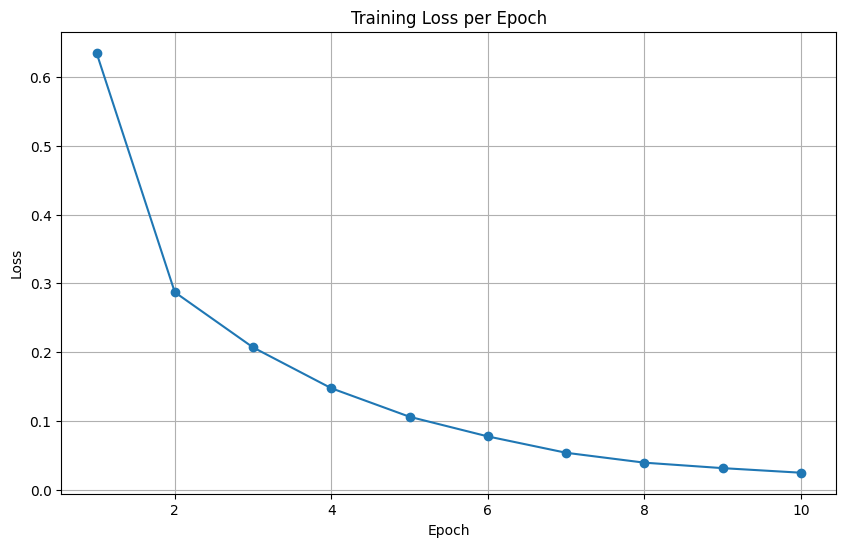

Accuracy: 0.9057


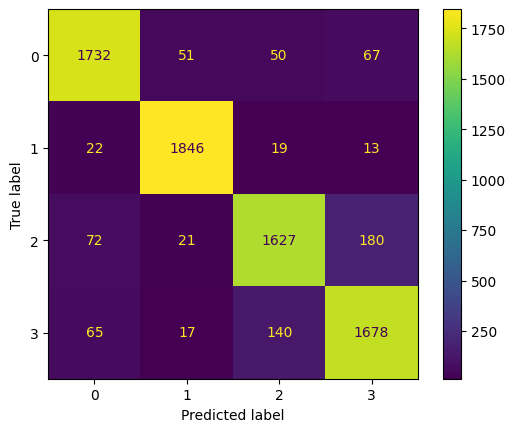

In [22]:
epochs = 10
lr = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES).to(device)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

# Entrenamiento y evaluación
train(rnn_model, optimiser, train_loader, epochs=epochs)
print(f'Accuracy: {accuracy(rnn_model, test_loader):.4f}')

# Matriz de confusión
plot_confusion_matrix(rnn_model, test_loader)
